In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

# you can choose one of the following package for image reading/processing

import cv2
import PIL


**1. Support Vector Machine**

In [9]:
# Load csv 
data = pd.read_csv("./x_train.csv")
label = pd.read_csv("./t_train.csv")

### 1.1

In [10]:
def MyPCA(data):
    data_new = data - np.mean(data, axis=0)
    assert(np.allclose(data_new.mean(axis=0), np.zeros(data_new.shape[1])))
    C = np.dot(data_new.T, data_new) /  (data_new.shape[0] - 1)
    eig_vals, eig_vecs = np.linalg.eig(C)
    X_pca = np.dot(data_new, eig_vecs)
    return X_pca.real * (-1)
print(MyPCA(data)[:,:2])

[[-1299.44142967   411.08932271]
 [  747.37963209   195.55249559]
 [ 1873.22937053   679.76393037]
 [ 2213.40151354  1151.49327593]
 [  454.89802613  -952.85283675]
 [-1457.94918888   575.27928736]
 [-1529.58767267   534.49712478]
 [  328.77936316 -1212.9684954 ]
 [  892.68760041 -1330.75532229]
 [ 1008.74194511 -1034.93953952]
 [ 1971.14649725   372.10266625]
 [  725.45766658 -1033.05176334]
 [-1424.82085571   422.20177942]
 [ -145.78733244 -1040.65091493]
 [  986.0469579  -1051.99576066]
 [ 1916.38276931   832.72063557]
 [  744.69197954 -1281.20375473]
 [ -982.24285818   706.47243715]
 [  178.40409415 -1178.83825266]
 [  738.73543975  -641.42492763]
 [  789.3958816  -1233.55719137]
 [-1673.5053648      2.87539119]
 [ -625.34437951   -74.7159641 ]
 [  -79.61713457   386.19091798]
 [ 1239.45485346  1434.29440871]
 [-1551.78018409   166.02768605]
 [ -987.54829515   841.55828067]
 [ 1198.56843499   937.60181974]
 [ -139.45664171  -915.134872  ]
 [   34.67875895   455.70298123]
 [  523.62

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

### 1.2

* **one-versus-the-rest** : 
> train K-1 times and every time we train k-th classifier(as positive examples), we compare to the rest K-1 classifiier(as negative example), but this method will make training set imbalanced.
* **one-versus-one** :
> train $C^K_2$ times and take a "majority vote" to choose the class.

I will choose *one-versus-one* because although the calculate time is larger, it more intuitively to implement while we only need to choose which class is the most often selected.

In [12]:
x_train = pca.fit_transform(data)
t_train = label.to_numpy().flatten()
print(x_train.shape, t_train.shape)

(299, 2) (299,)


In [ ]:
class SVM:
    def __init__(self, kernel:str, C=1.0) -> None:
        self.C = C
        self.mode = kernel
        self.W = None
        self.b = None

    def Phi(self, x, mode):
        if mode == 'linear':
            return x
        elif mode == 'polynomial':
            if len(x.shape) == 1:
                x1, x2 = x[0], x[1]
                return np.array([x1**2, np.sqrt(2)*x1*x2, x2**2])
            if len(x.shape) == 2:
                x1, x2 = np.expand_dims(x[:, 0], 1), np.expand_dims(x[:, 1], 1)
                return np.concatenate((x1**2, np.sqrt(2)*x1*x2, x2**2), axis=1)
            else:
                raise ValueError("mode must be 'linear' or 'polynomial'")

    def Kernel(self, xi, xj):
        return np.dot(xi ,xj.T)

    def fit(self, x_train, t_train):
        self.X = x_train
        self.y = t_train
        self.sample_number = x_train.shape[0]
        self.classes = np.unique(t_train)
        self.classes_number = len(np.unique(t_train))
        self.one_vs_one_list = [(0, 1), (0, 2), (1, 2)]
        self.dual_coef_ = clf.dual_coef_
        self.support_ = clf.support_
        self.lagrange_coef = np.abs(clf.dual_coef_)
        self.t = self.make_target(t_train)
        self.support_lagrange_coef = self.get_largrange_multiplier(t_train)
        self.W, self.b = self.get_parameters()

    def predict(self, X):
        return np.array([self.get_classes(data, idx) for idx, data in enumerate(X)])

    def get_classes(self, x, idx):
        x = self.Phi(x, self.mode)
        n_votes = []
        counter = {}
        for i in self.one_vs_one_list:
            W = self.W[i]
            b = self.b[i]
            coef_t = self.support_lagrange_coef[i]*self.t[i]
            y = np.sign(np.dot(W, x.T) + b)
            if y == 1:
                n_votes.append(i[0])
            else:
                n_votes.append(i[1])
        for c in n_votes:
            counter[c] = counter.get(c, 0) + 1 
        return max(counter, key=counter.get)

    def make_target(self, y):
        t = {}
        for cls in self.one_vs_one_list:
            
            t[cls] = np.zeros(self.sample_number)
            one_idx = np.where(y == cls[0])
            neg_one_idx = np.where(y == cls[1])
            t[cls][one_idx] = np.ones(len(one_idx))
            t[cls][neg_one_idx] = np.full(len(neg_one_idx), -1)
        return t

    def get_largrange_multiplier(self, y):
        a = np.zeros((self.sample_number, self.classes_number-1))
        a[self.support_] = self.lagrange_coef.T

        coef_indices = [(0, 0), (0, 1), (1, 1)] 
        lagrange_coef = {}
        for c, coef_idx in zip(self.one_vs_one_list, coef_indices):
            lagrange_coef[c] = np.zeros(self.sample_number)
            idx_0 = np.where(y==c[0]) 
            idx_1 = np.where(y==c[1]) 
            lagrange_coef[c][idx_0] = a[idx_0, coef_idx[1]]
            lagrange_coef[c][idx_1] = a[idx_1, coef_idx[0]]
        return lagrange_coef

    def get_parameters(self, threshold=0):
        X = self.Phi(self.X, self.mode)
        W = {}
        b = {}
        for c in self.one_vs_one_list:
            coef = self.support_lagrange_coef[c]
            coef_t = self.support_lagrange_coef[c]*self.t[c]
            t = self.t[c]
            W[c] = np.dot(coef_t, X)
            m_idx = np.where((coef > threshold) & (coef < self.C))[0]
            s_idx = np.nonzero(coef)[0]
            b[c] = np.mean(t[m_idx] - np.dot(coef_t[s_idx], self.Kernel(X[m_idx], X[s_idx]).T))
        return W, b

    def plot(self):
        
        classes_  = ['T-shirt/top','Trouser','Sandal']
        num = 500
        space = 1
        x1 = np.linspace(np.min(self.X[:,0])-space, np.max(self.X[:,0])+space, num=num)
        x2 = np.linspace(np.min(self.X[:,1])-space, np.max(self.X[:,1])+space, num=num)
        xx, yy = np.meshgrid(x1, x2)
        xy = np.c_[xx.flatten(), yy.flatten()]
        z = self.predict(xy).reshape(xx.shape)
        
        n_classes = np.unique(self.y)
        i=0
        for c in n_classes:
            c_idx = np.where(self.y==c)[0]
            X_c = self.X[c_idx]
            plt.scatter(X_c[:,0], X_c[:,1], marker='x', label=f'{classes_[i]}')
            i+=1
        x_sv, y_sv = self.X[self.support_, 0], self.X[self.support_, 1]
        plt.scatter(x_sv, y_sv, facecolors='None', edgecolors='k', linewidths=1, label="Support Vector")
        plt.title(f'{self.mode} kernel')
        plt.contourf(xx, yy, z, alpha=0.3)
        plt.legend()

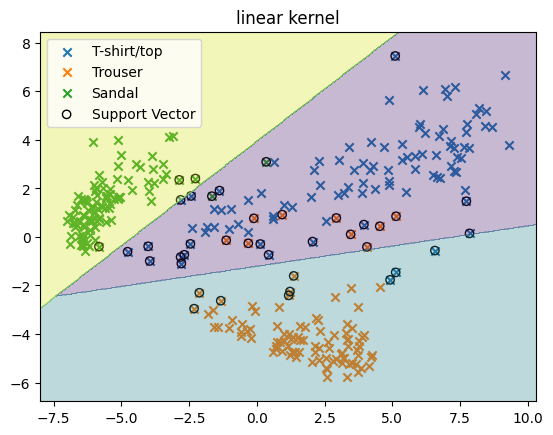

In [ ]:
# Linear kernel
clf = svm.SVC(kernel='linear', decision_function_shape='ovo')
clf.fit(x_train, t_train)
model = SVM(kernel = 'linear')
model.fit(x_train, t_train)
model.plot()

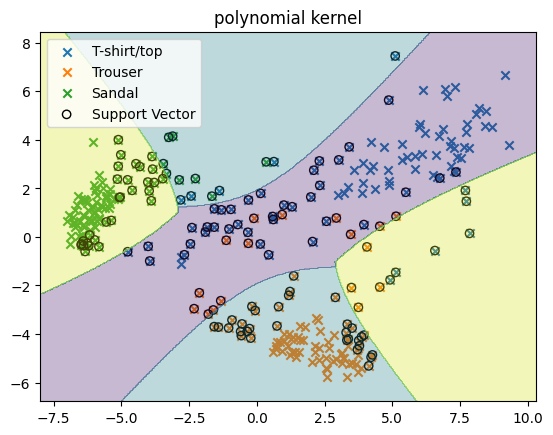

In [ ]:
# Polynomial kernel
clf = svm.SVC(kernel='poly', decision_function_shape='ovo', degree=2)
clf.fit(x_train, t_train)
model = SVM(kernel = 'polynomial')
model.fit(x_train, t_train)
model.plot()

**2. Gaussian Mixture Model**

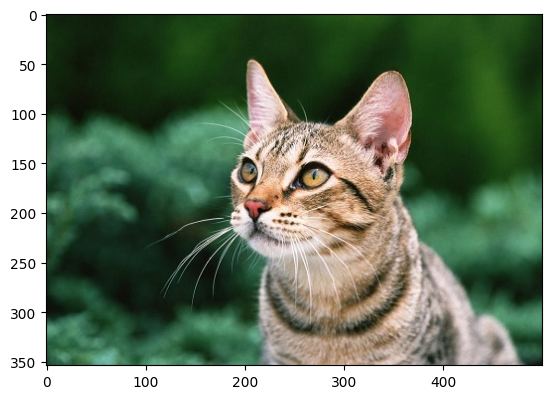

In [8]:
image = cv2.imread("./hw3.jpg")
image.shape
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### 2.1

In [9]:
class Kmeans:
    def __init__(self, image,k:int) -> None:
        self.k = k
        self.h, self.w, _ = image.shape
        self.r = np.zeros((self.h*self.w, self.k))
        self.image = image.reshape((-1,3)) # (177000 , 3)
        self.img = image
        self.mu = self.init_mu()
        
    def init_mu(self):
        self.mu = self.img[np.random.randint(0, self.h), np.random.randint(0, self.w)]
        for i in range(self.k-1):
            x = np.random.randint(0, self.h)
            y = np.random.randint(0, self.w)
            mu_tmp = self.img[x,y]
            self.mu = np.vstack([self.mu, mu_tmp])
        return self.mu # (k , 3)
    
    def update_r(self):
        pixels = self.h*self.w
        r_mat = np.zeros((1, pixels)) # (354 * 500, k)
        cls = np.argmin((np.linalg.norm(self.image[:, :, None] - self.mu.T[None,:,:], axis=1)), axis=1)   
        for k in range(self.k):
            tmp = np.where(cls == k, 1, 0) 
            r_mat = np.vstack([r_mat, tmp])  
        self.r = r_mat[1:] 
        return self.r    # (k , 17700)

    def update_mu(self):
        self.mu = np.sum((self.r.T[:,:,None] * self.image[:,None,:]), axis=0) / np.sum(self.r[:,:,None], axis=1)
        return self.mu  # (k , 3)

    def draw(self):
        res = np.matmul(self.mu.T, self.r)
        res = (res.T).reshape((self.h, self.w, 3))
        # plt.title(f"K = {self.k}")
        res = np.flip(res, axis=2)
        # plt.imshow(res)
        return res


### 2.2 & 2.3

In [10]:
# Gaussian Mixture Model
class GMM:
    def __init__(self, K_means:Kmeans) -> None:
        self.mu = K_means.mu
        self.image = K_means.image
        self.gamma = K_means.r # (k , 17700)
        self.N_k = np.sum(self.gamma, axis=1)
        self.N =  K_means.h * K_means.w
        self.pi = self.N_k / self.N # (k ,  1)
        self.k = K_means.k
        self.cov = np.dstack([np.eye(3)] * self.k)
        
    def E_step(self):
        gaussian_list = []
        for k in range(self.k):
            gaussian_list.append(self.pi[k] * multivariate_normal.pdf(self.image, self.mu[k], self.cov[:, :, k]))
        gaussian = np.array(gaussian_list)
        self.gamma = gaussian / np.sum(gaussian, axis=0) # gamma = (k , 177000)
        self.N_k = np.sum(self.gamma, axis=1)
        pass

    def M_step(self):
        self.mu = (np.sum(self.gamma.T[:,:,None] * self.image[:,None,:], axis=0)) / self.N_k[:,None] # update mu , mu = (k , 3)
        for k in range(self.k):
            self.cov[:,:,k] = np.sum(self.gamma[k][:,None,None] * (((self.image - self.mu[k,:])[:, None, :] )* ((self.image - self.mu[k,:])[:, : , None])), axis=0) / self.N_k[k] # update cov
        self.pi = self.N_k / self.N # update pi
        pass

    def log_likelihood(self):
        gaussian_list = []
        for k in range(self.k):
            gaussian_list.append(self.pi[k] * multivariate_normal.pdf(self.image, self.mu[k], self.cov[:, : ,k]))
        ans = np.sum(np.log(np.sum(np.array(gaussian_list), axis=0)))
        return ans
    
    def draw(self):
        res = np.matmul(self.mu.T, self.gamma)
        res = (res.T).reshape((K_means.h, K_means.w, 3))
        # plt.title(f"K = {K_means.k}")
        res = np.flip(res, axis=2)
        # plt.imshow(res)
        return res

        


The estimated mu:
[[0.5781336  0.6495205  0.69402348]
 [0.14574442 0.26769697 0.13834579]]


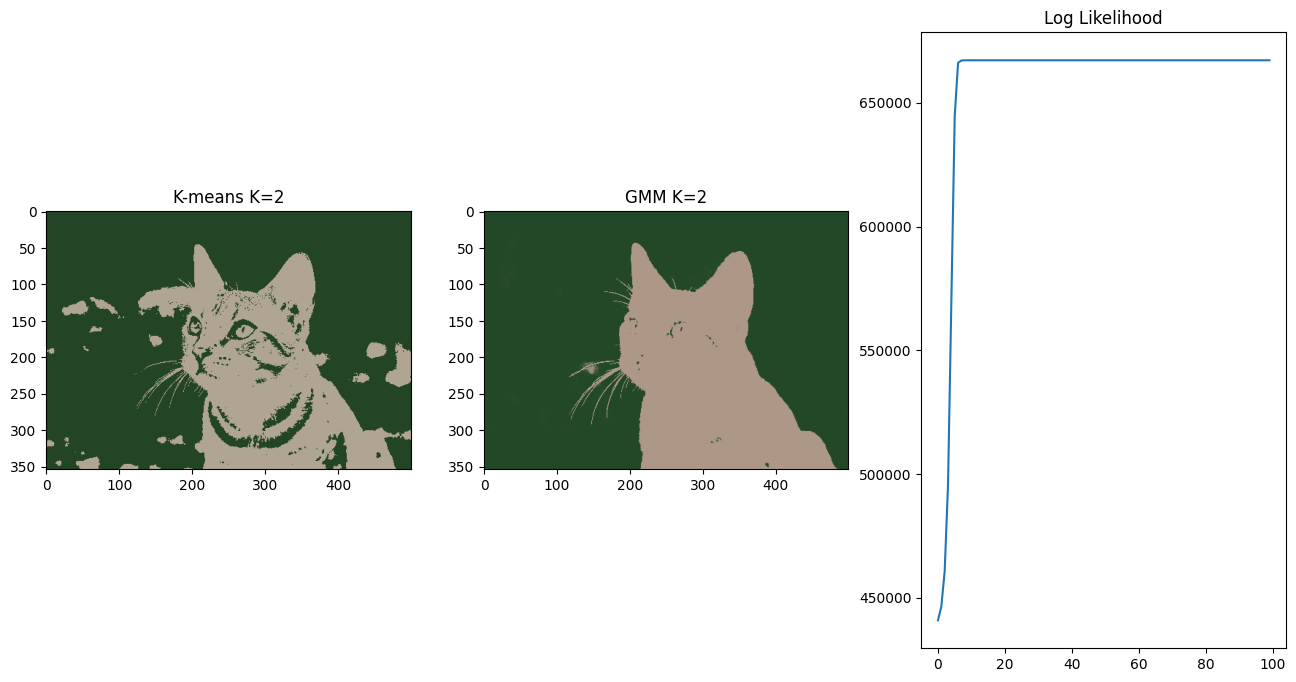

In [11]:
# K = 2
image = image/255
k=2
K_means = Kmeans(image, k)
for i in range(100):
    K_means.update_r() # E-step
    K_means.update_mu() # M-step 
print("The estimated mu:")
print(K_means.mu)
KM_image = K_means.draw()
gmm = GMM(K_means)
loss = []
for i in range(100):
    gmm.E_step()
    gmm.M_step()
    loss.append(gmm.log_likelihood())
gmm_image = gmm.draw()
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title(f"K-means K={k}")
plt.imshow(KM_image)
plt.subplot(132)
plt.title(f"GMM K={k}")
plt.imshow(gmm_image)
plt.subplot(133)
plt.title("Log Likelihood")
plt.plot(loss)

The estimated mu:
[[0.3530994  0.46960726 0.33068237]
 [0.64166138 0.6982961  0.79120077]
 [0.0901531  0.21234828 0.09684794]]


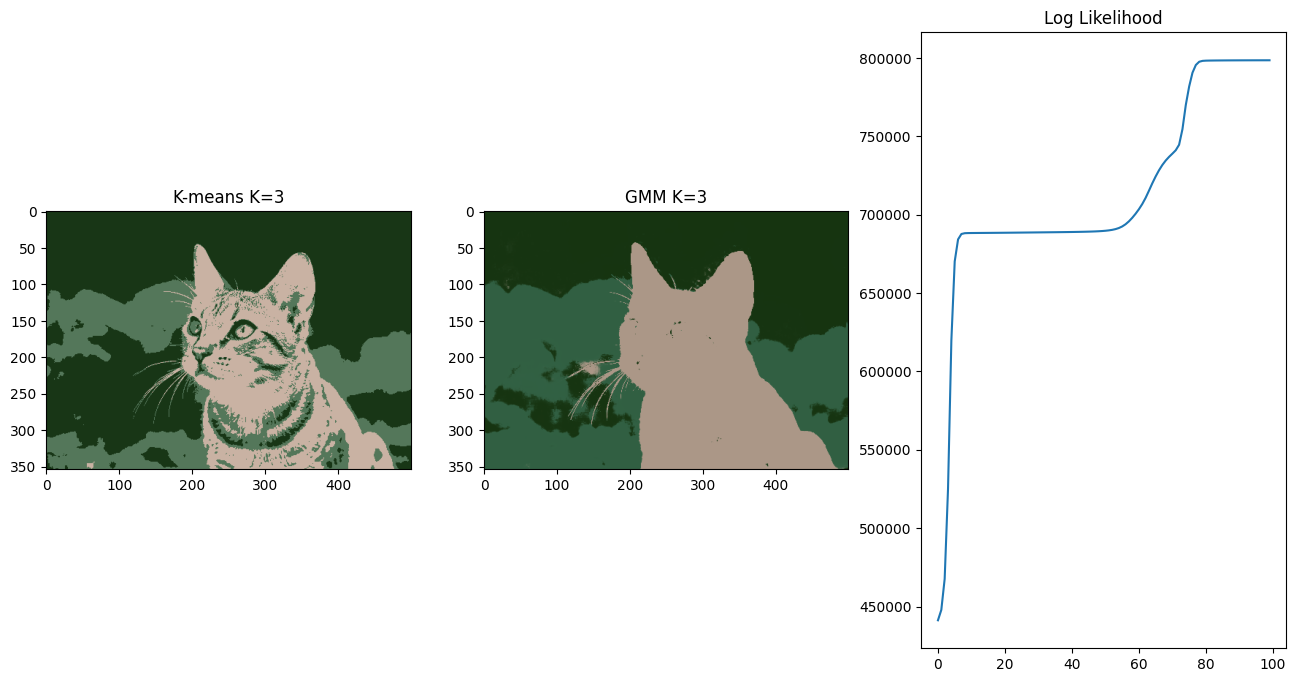

In [12]:
# K = 3
k=3
K_means = Kmeans(image, k)
for i in range(100):
    K_means.update_r() # E-step
    K_means.update_mu() # M-step 
print("The estimated mu:")
print(K_means.mu)
KM_image = K_means.draw()
gmm = GMM(K_means)
loss = []
for i in range(100):
    gmm.E_step()
    gmm.M_step()
    loss.append(gmm.log_likelihood())
gmm_image = gmm.draw()
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title(f"K-means K={k}")
plt.imshow(KM_image)
plt.subplot(132)
plt.title(f"GMM K={k}")
plt.imshow(gmm_image)
plt.subplot(133)
plt.title("Log Likelihood")
plt.plot(loss)

In [13]:
# K = 7
k=7
K_means = Kmeans(image, k)
for i in range(100):
    K_means.update_r() # E-step
    K_means.update_mu() # M-step 
print("The estimated mu:")
print(K_means.mu)
KM_image = K_means.draw()
gmm = GMM(K_means)
loss = []
for i in range(100):
    gmm.E_step()
    gmm.M_step()
    loss.append(gmm.log_likelihood())
gmm_image = gmm.draw()
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title(f"K-means K={k}")
plt.imshow(KM_image)
plt.subplot(132)
plt.title(f"GMM K={k}")
plt.imshow(gmm_image)
plt.subplot(133)
plt.title("Log Likelihood")
plt.plot(loss)

In [ ]:
# K = 20
k=20
K_means = Kmeans(image, k)
for i in range(100):
    K_means.update_r() # E-step
    K_means.update_mu() # M-step 
print("The estimated mu:")
print(K_means.mu)
KM_image = K_means.draw()
gmm = GMM(K_means)
loss = []
for i in range(100):
    gmm.E_step()
    gmm.M_step()
    loss.append(gmm.log_likelihood())
gmm_image = gmm.draw()
plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title(f"K-means K={k}")
plt.imshow(KM_image)
plt.subplot(132)
plt.title(f"GMM K={k}")
plt.imshow(gmm_image)
plt.subplot(133)
plt.title("Log Likelihood")
plt.plot(loss)

### 2.4

* From k=2, we can see that the GMM clustering the image such that the cat and backgroud seperate very clear, and k-means show more detail of edge, I guess it is because k-means is lean to cluster the nearest neighbor of $\mu$ of every pixel. In contrast, GMM use Gaussian distribution and use probability to estimate the $\mu$